In [1]:
%matplotlib inline
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('float_format', '{:f}'.format)

def plotPlayer(id):
    player = id
    fig = plt.figure(figsize=(10, 6))
    ax = fig.gca()
    df[df['id'] == player][['wrating', 'age']].set_index('age').sort_index().plot(ax=ax)
    df[df['id'] == player][['rating', 'age']].set_index('age').sort_index().plot(ax=ax)
    return (df[df['id'] == player][['wrating', 'tour', 'age', 'team', 'start']].set_index('age').sort_index())

In [2]:
def load_csv(system):
    df = pd.read_csv(system + '.csv', encoding="utf-8")
    df.start = pd.to_datetime(df.start, format='%d/%m/%Y')
    df.end = pd.to_datetime(df.end, format='%d/%m/%Y')
    dob = pd.read_csv('dob.csv', encoding="utf-8")
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    return df, dob

def cumulativeRating(diff, ratingName, df):
    cumsums = df[['id', 'start', diff]].groupby(['id', 'start']).sum().groupby(level=0).cumsum()
    df = df.set_index(['id', 'start'])
    df['cumur'] = cumsums
    df = df.reset_index()
    init = df[df['startglicko2rating'].notnull()].sort_values('start')[['startglicko2rating', 'id']].groupby('id').first().reset_index().rename(columns={'startglicko2rating': 'init'})
    df = pd.merge(df, init, how='left', on='id')
    df[ratingName] = df.cumur + df.init
    return df

def teamRating(rating, df):
    teameff = df.merge((df.groupby(['team', 'start']).mean()[rating] * 5).reset_index().rename(columns={rating: 'teamrating'}), on=['team', 'start'])
    teameff.teamrating = (teameff.teamrating - teameff[rating]) / 4
    return teameff

def experience(df):
    dfid2 = pd.DataFrame()
    for player in df.id.unique():
        dfid = pd.DataFrame(df[df['id'] == player].sort_values('start').tour.unique()).reset_index().rename(columns={'index': 'exp', 0: 'tour'})
        dfid['id'] = player
        dfid2 = pd.concat([dfid2, dfid])
    return pd.merge(df, dfid2, how='left', on=['id', 'tour'])
    
def dobMerge(df, dob):
    dob.id = dob.id.str.replace(r'\W+', '').str.lower()
    df = df.merge(dob, how='left', on=['id'])
    df.dob = pd.to_datetime(df.dob, format='%Y/%m/%d')
    df['age'] = (df.start - df.dob) / pd.Timedelta(days=365.25)
    return df

In [3]:
df, dob = load_csv('glickoandprize')
df['diffr'] = df.endglicko2rating - df.startglicko2rating
df = cumulativeRating('diffr', 'normalRating', df)
df = teamRating('normalRating', df)
df = experience(df)
df.drop_duplicates(subset=['id', 'start'], inplace=True)

In [4]:
df, dob = load_csv('glickoandprize')
df['diffr'] = df.endglicko2rating - df.startglicko2rating
df = cumulativeRating('diffr', 'normalRating', df)
df = teamRating('normalRating', df)
df = experience(df)
df.drop_duplicates(subset=['id', 'start'], inplace=True)
df.dropna(inplace=True)
df = dobMerge(df, dob)
df.dropna(inplace=True)
df = df[(df.prizepool != 'Nan')]
df.prizepool = pd.to_numeric(df.prizepool)
df.prizeusd = pd.to_numeric(df.prizeusd.str.replace(r'\D', ''))

In [5]:
df['season'] = 'ti3'
df.loc[(df.start > pd.to_datetime('2013-08-02')) & (df.start <= pd.to_datetime('2014-07-08')), 'season'] = 'ti4'
df.loc[(df.start > pd.to_datetime('2014-07-08')) & (df.start <= pd.to_datetime('2015-07-27')), 'season'] = 'ti5'
df.loc[(df.start > pd.to_datetime('2015-07-27')) & (df.start <= pd.to_datetime('2016-08-02')), 'season'] = 'ti6'
df.loc[(df.start > pd.to_datetime('2016-08-02')) & (df.start <= pd.to_datetime('2017-08-02')), 'season'] = 'ti7'

In [6]:
df['tiprize'] = np.log(int(df[df['tour'] == 'The International 2013'].prizepool.iloc[0]))
df.loc[(df.season == 'ti4'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2014'].prizepool.iloc[0]))
df.loc[(df.season == 'ti5'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2015'].prizepool.iloc[0]))
df.loc[(df.season == 'ti6'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2016'].prizepool.iloc[0]))
df.loc[(df.season == 'ti7'), 'tiprize'] = np.log(int(df[df['tour'] == 'The International 2017'].prizepool.iloc[0]))

df['perf'] = df.diffr + df.init

In [7]:
ent = pd.DataFrame(df.id.unique()).reset_index().rename(columns={'index': 'entity', 0: 'id'})
df = ent.merge(df, on='id', how='left')

In [8]:
pd.set_option('float_format', '{:f}'.format)

In [9]:
df.head()

,entity,id,start,Unnamed: 0,team,pos,tour,prizepool,place,prizeusd,...,normalRating,teamrating,exp,cog,name,dob,age,season,tiprize,perf
0,0,mushi,2012-09-08,0,orangeesports,1,WCG Asian Championship 2012,6000.000000,1,3000,...,1444.955065,1444.955065,0,Malaysia,Chai Yee Fung,1990-11-27,21.782341,ti3,14.871348,1444.955065
1,0,mushi,2012-10-22,216,orangeesports,2,G-1 Champions League Season 4,52879.200000,3,8012,...,1510.112208,1523.880083,1,Malaysia,Chai Yee Fung,1990-11-27,21.902806,ti3,14.871348,1512.188495
2,0,mushi,2012-11-29,671,orangeesports,2,World Cyber Games 2012,33000.000000,4,0,...,1508.050230,1498.644882,2,Malaysia,Chai Yee Fung,1990-11-27,22.006845,ti3,14.871348,1444.969374
3,0,mushi,2014-05-24,4891,dk,2,MarsTV Dota 2 League 2014,24046.500000,3-4,160310,...,1520.547879,1751.074995,21,Malaysia,Chai Yee Fung,1990-11-27,23.488022,ti4,16.206471,1459.529001
4,0,mushi,2015-01-05,6679,lvgaming,5,Dota 2 League Season 5,58397.000000,1,26679,...,1518.057989,1687.607441,29,Malaysia,Chai Yee Fung,1990-11-27,24.106776,ti5,16.729469,1444.541461


In [10]:
nt = df.groupby('id').size().reset_index()
df = df[df['id'].isin(nt[nt[0] >= 10].id.unique())]

In [11]:
df.head()

,entity,id,start,Unnamed: 0,team,pos,tour,prizepool,place,prizeusd,...,normalRating,teamrating,exp,cog,name,dob,age,season,tiprize,perf
0,0,mushi,2012-09-08,0,orangeesports,1,WCG Asian Championship 2012,6000.000000,1,3000,...,1444.955065,1444.955065,0,Malaysia,Chai Yee Fung,1990-11-27,21.782341,ti3,14.871348,1444.955065
1,0,mushi,2012-10-22,216,orangeesports,2,G-1 Champions League Season 4,52879.200000,3,8012,...,1510.112208,1523.880083,1,Malaysia,Chai Yee Fung,1990-11-27,21.902806,ti3,14.871348,1512.188495
2,0,mushi,2012-11-29,671,orangeesports,2,World Cyber Games 2012,33000.000000,4,0,...,1508.050230,1498.644882,2,Malaysia,Chai Yee Fung,1990-11-27,22.006845,ti3,14.871348,1444.969374
3,0,mushi,2014-05-24,4891,dk,2,MarsTV Dota 2 League 2014,24046.500000,3-4,160310,...,1520.547879,1751.074995,21,Malaysia,Chai Yee Fung,1990-11-27,23.488022,ti4,16.206471,1459.529001
4,0,mushi,2015-01-05,6679,lvgaming,5,Dota 2 League Season 5,58397.000000,1,26679,...,1518.057989,1687.607441,29,Malaysia,Chai Yee Fung,1990-11-27,24.106776,ti5,16.729469,1444.541461


In [12]:
def panelOLSResult(df, Y, X):
    from linearmodels import PanelOLS 
    panel_data = df.set_index(['entity', 'start']).sort_index()
    panel_data['agesq'] = panel_data.age ** 2
    panel_data['const'] = 1
    panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)
    Y = panel_data[Y]
    X = panel_data[X]
    mod = PanelOLS(Y, X, entity_effects=True)
    return mod.fit()

def feResult(res):
    fe = res.estimated_effects.reset_index().drop_duplicates().drop_duplicates(subset=['entity']).drop('time', 1)
    return ent.merge(fe, on='entity').sort_values('estimated_effects', ascending=False)

### Age and experience

In [13]:
from linearmodels import PanelOLS 
panel_data = df[['entity', 'start', 'perf', 'age', 'exp', 'pos']].set_index(['entity', 'start']).sort_index()
panel_data['agesq'] = panel_data.age ** 2
panel_data['const'] = 1
panel_data['lexp'] = (panel_data['exp'] + 1).apply(np.log)

In [14]:
len(df.entity.unique())

164

In [15]:
df.head()

,entity,id,start,Unnamed: 0,team,pos,tour,prizepool,place,prizeusd,...,normalRating,teamrating,exp,cog,name,dob,age,season,tiprize,perf
0,0,mushi,2012-09-08,0,orangeesports,1,WCG Asian Championship 2012,6000.000000,1,3000,...,1444.955065,1444.955065,0,Malaysia,Chai Yee Fung,1990-11-27,21.782341,ti3,14.871348,1444.955065
1,0,mushi,2012-10-22,216,orangeesports,2,G-1 Champions League Season 4,52879.200000,3,8012,...,1510.112208,1523.880083,1,Malaysia,Chai Yee Fung,1990-11-27,21.902806,ti3,14.871348,1512.188495
2,0,mushi,2012-11-29,671,orangeesports,2,World Cyber Games 2012,33000.000000,4,0,...,1508.050230,1498.644882,2,Malaysia,Chai Yee Fung,1990-11-27,22.006845,ti3,14.871348,1444.969374
3,0,mushi,2014-05-24,4891,dk,2,MarsTV Dota 2 League 2014,24046.500000,3-4,160310,...,1520.547879,1751.074995,21,Malaysia,Chai Yee Fung,1990-11-27,23.488022,ti4,16.206471,1459.529001
4,0,mushi,2015-01-05,6679,lvgaming,5,Dota 2 League Season 5,58397.000000,1,26679,...,1518.057989,1687.607441,29,Malaysia,Chai Yee Fung,1990-11-27,24.106776,ti5,16.729469,1444.541461


In [16]:
df.describe()

,entity,Unnamed: 0,pos,prizepool,prizeusd,startglicko2mu,startglicko2phi,startglicko2rating,endglicko2mu,endglicko2phi,endglicko2rating,diffr,cumur,init,normalRating,teamrating,exp,age,tiprize,perf
count,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000
mean,89.689570,6918.633203,2.996091,1342571.963859,264136105.668792,1841.128250,42.634076,1734.543059,1845.487274,41.275249,1742.299152,7.756094,271.002323,1598.728616,1869.730939,1856.011608,26.041761,22.639532,16.463026,1606.484709
std,61.968073,3386.208016,1.415299,4296199.481134,3622600182.947815,97.213157,6.576886,102.479247,95.447060,5.895585,98.937645,36.491342,266.747862,94.677296,252.564205,186.150147,17.359077,2.498968,0.683499,98.987887
min,0.000000,0.000000,1.000000,4410.000000,0.000000,1542.725781,28.869240,1377.868237,1514.769232,27.318820,1356.623107,-276.817659,-482.341083,1377.868237,1120.965747,1321.284974,0.000000,15.739904,14.871348,1284.144230
25%,35.000000,4248.000000,2.000000,39000.000000,1500.000000,1778.144576,38.363352,1663.140303,1780.646087,37.368550,1674.632933,-7.215598,61.783916,1540.350904,1698.604900,1721.643107,12.000000,20.941821,16.206471,1540.101556
50%,81.000000,7312.000000,3.000000,100000.000000,14000.000000,1847.199041,41.489108,1742.696820,1849.448321,40.319949,1752.012918,-2.845417,234.288187,1603.306830,1841.067619,1847.128391,22.000000,22.696783,16.729469,1603.708255
75%,134.000000,9622.000000,4.000000,277668.000000,96860.000000,1913.222326,44.995443,1811.580851,1915.028650,43.742622,1814.618714,17.657349,429.964957,1645.784093,2005.501781,1983.505873,37.000000,24.399726,16.849042,1663.391830
max,232.000000,12374.000000,5.000000,24787916.000000,102512933715.000000,2070.341655,69.914737,1952.785682,2089.277451,68.869853,1972.493488,208.528743,1170.654012,1898.778787,2698.966417,2411.544440,83.000000,29.333333,17.025867,1942.455823


In [17]:
panel_data.describe()

,perf,age,exp,pos,agesq,const,lexp
count,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000,4861.000000
mean,1606.484709,22.639532,26.041761,2.996091,518.791967,1.000000,3.041507
std,98.987887,2.498968,17.359077,1.415299,112.871091,0.000000,0.798491
min,1284.144230,15.739904,0.000000,1.000000,247.744583,1.000000,0.000000
25%,1540.101556,20.941821,12.000000,2.000000,438.559853,1.000000,2.564949
50%,1603.708255,22.696783,22.000000,3.000000,515.143960,1.000000,3.135494
75%,1663.391830,24.399726,37.000000,4.000000,595.346639,1.000000,3.637586
max,1942.455823,29.333333,83.000000,5.000000,860.444444,1.000000,4.430817


In [25]:
Y = panel_data['perf']
X = panel_data[['age', 'agesq', 'lexp']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.0502
Estimator:,PanelOLS,R-squared (Between):,-0.2054
No. Observations:,4861,R-squared (Within):,0.0502
Date:,"Tue, May 01 2018",R-squared (Overall):,-0.2101
Time:,12:21:12,Log-likelihood,-2.414e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,82.644
Entities:,164,P-value,0.0000
Avg Obs:,29.640,Distribution:,"F(3,4694)"
Min Obs:,10.0000,,
Max Obs:,76.000,F-statistic (robust):,82.644


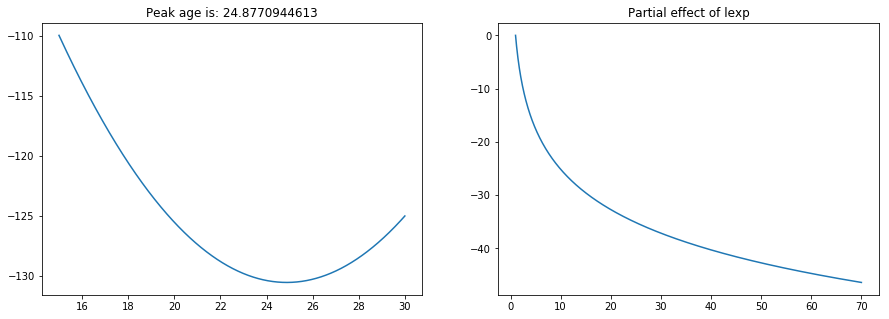

In [26]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
lexp = res.params.lexp*np.log(lexpx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Peak age is: " + str(-res.params.age / (2 * res.params.agesq)))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

In [27]:
core = panel_data[panel_data['pos'] <= 3]
core.describe()

,perf,age,exp,pos,agesq,const,lexp
count,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000,2914.000000
mean,1608.583266,22.496290,25.924159,1.994852,512.184704,1.000000,3.029324
std,104.181358,2.470570,17.350907,0.819209,110.687884,0.000000,0.816306
min,1284.144230,15.739904,0.000000,1.000000,247.744583,1.000000,0.000000
25%,1540.305208,20.909651,12.000000,1.000000,437.213503,1.000000,2.564949
50%,1605.618538,22.607803,22.000000,2.000000,511.112753,1.000000,3.135494
75%,1673.618917,24.209446,37.000000,3.000000,586.097261,1.000000,3.637586
max,1942.455823,29.333333,83.000000,3.000000,860.444444,1.000000,4.430817


In [28]:
Y = core['perf']
X = core[['age', 'agesq', 'lexp']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.0499
Estimator:,PanelOLS,R-squared (Between):,-0.3164
No. Observations:,2914,R-squared (Within):,0.0499
Date:,"Tue, May 01 2018",R-squared (Overall):,-0.3209
Time:,12:21:26,Log-likelihood,-1.44e+04
Cov. Estimator:,Unadjusted,,
,,F-statistic:,48.594
Entities:,164,P-value,0.0000
Avg Obs:,17.768,Distribution:,"F(3,2777)"
Min Obs:,0.0000,,
Max Obs:,68.000,F-statistic (robust):,48.594


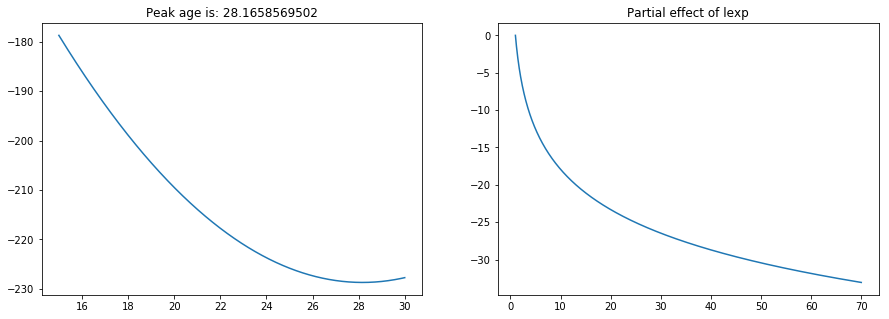

In [29]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
lexp = res.params.lexp*np.log(lexpx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Peak age is: " + str(-res.params.age / (2 * res.params.agesq)))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

In [30]:
sup = panel_data[panel_data['pos'] >= 4]
sup.describe()

,perf,age,exp,pos,agesq,const,lexp
count,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000,1947.000000
mean,1603.343881,22.853916,26.217771,4.494607,528.680803,1.000000,3.059741
std,90.596334,2.526379,17.374268,0.500099,115.385559,0.000000,0.770906
min,1304.637290,16.501027,0.000000,4.000000,272.283882,1.000000,0.000000
25%,1538.684440,21.029432,13.000000,4.000000,442.237013,1.000000,2.639057
50%,1601.333697,22.822724,22.000000,4.000000,520.876738,1.000000,3.135494
75%,1650.307942,24.854209,37.000000,5.000000,617.731727,1.000000,3.637586
max,1907.066627,28.670773,79.000000,5.000000,822.013250,1.000000,4.382027


In [31]:
Y = sup['perf']
X = sup[['age', 'agesq', 'lexp']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.0518
Estimator:,PanelOLS,R-squared (Between):,-0.0858
No. Observations:,1947,R-squared (Within):,0.0518
Date:,"Tue, May 01 2018",R-squared (Overall):,-0.0901
Time:,12:21:30,Log-likelihood,-9678.9
Cov. Estimator:,Unadjusted,,
,,F-statistic:,33.541
Entities:,162,P-value,0.0000
Avg Obs:,12.019,Distribution:,"F(3,1843)"
Min Obs:,0.0000,,
Max Obs:,73.000,F-statistic (robust):,33.541


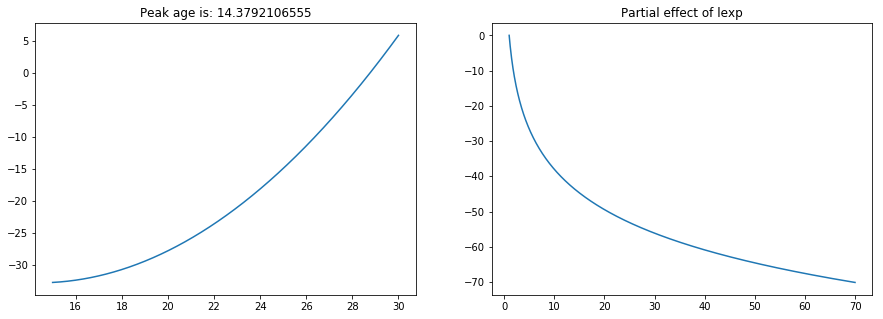

In [32]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
lexp = res.params.lexp*np.log(lexpx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Peak age is: " + str(-res.params.age / (2 * res.params.agesq)))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

In [33]:
pos1 = panel_data[panel_data['pos'] == 1]
pos1.describe()

,perf,age,exp,pos,agesq,const,lexp
count,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000,985.000000
mean,1599.994665,22.629829,28.490355,1.000000,518.735037,1.000000,3.149038
std,106.897760,2.575382,17.603762,0.000000,118.550085,0.000000,0.773032
min,1284.144230,16.720055,0.000000,1.000000,279.560231,1.000000,0.000000
25%,1536.143176,20.908966,14.000000,1.000000,437.184878,1.000000,2.708050
50%,1605.596375,22.554415,26.000000,1.000000,508.701626,1.000000,3.295837
75%,1659.073929,24.169747,41.000000,1.000000,584.176658,1.000000,3.737670
max,1914.612444,29.333333,83.000000,1.000000,860.444444,1.000000,4.430817


In [34]:
Y = pos1['perf']
X = pos1[['age', 'agesq', 'lexp']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.0760
Estimator:,PanelOLS,R-squared (Between):,-0.5999
No. Observations:,985,R-squared (Within):,0.0760
Date:,"Tue, May 01 2018",R-squared (Overall):,-0.6048
Time:,12:21:37,Log-likelihood,-4875.5
Cov. Estimator:,Unadjusted,,
,,F-statistic:,24.829
Entities:,160,P-value,0.0000
Avg Obs:,6.1562,Distribution:,"F(3,906)"
Min Obs:,0.0000,,
Max Obs:,65.000,F-statistic (robust):,24.829


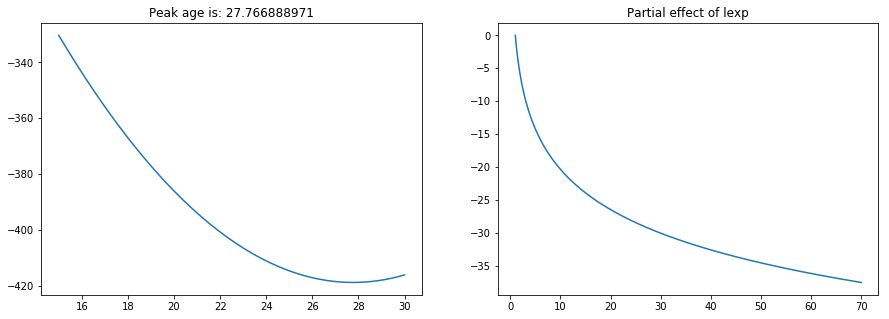

In [35]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
lexp = res.params.lexp*np.log(lexpx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Peak age is: " + str(-res.params.age / (2 * res.params.agesq)))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

In [36]:
pos2 = panel_data[panel_data['pos'] == 2]
pos2.describe()

,perf,age,exp,pos,agesq,const,lexp
count,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000,959.000000
mean,1613.360658,21.583329,24.088634,2.000000,471.405250,1.000000,2.918821
std,113.731461,2.360294,17.653752,0.000000,101.050674,0.000000,0.873253
min,1359.897702,15.739904,0.000000,2.000000,247.744583,1.000000,0.000000
25%,1537.611574,20.071184,10.500000,2.000000,402.852462,1.000000,2.441401
50%,1600.430980,21.650924,20.000000,2.000000,468.762511,1.000000,3.044522
75%,1687.803327,23.333333,34.000000,2.000000,544.444446,1.000000,3.555348
max,1942.455823,27.709788,71.000000,2.000000,767.832341,1.000000,4.276666


In [37]:
Y = pos2['perf']
X = pos2[['age', 'agesq', 'lexp']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.0521
Estimator:,PanelOLS,R-squared (Between):,-0.1513
No. Observations:,959,R-squared (Within):,0.0521
Date:,"Tue, May 01 2018",R-squared (Overall):,-0.1562
Time:,12:21:38,Log-likelihood,-4666.7
Cov. Estimator:,Unadjusted,,
,,F-statistic:,16.130
Entities:,163,P-value,0.0000
Avg Obs:,5.8834,Distribution:,"F(3,881)"
Min Obs:,0.0000,,
Max Obs:,66.000,F-statistic (robust):,16.130


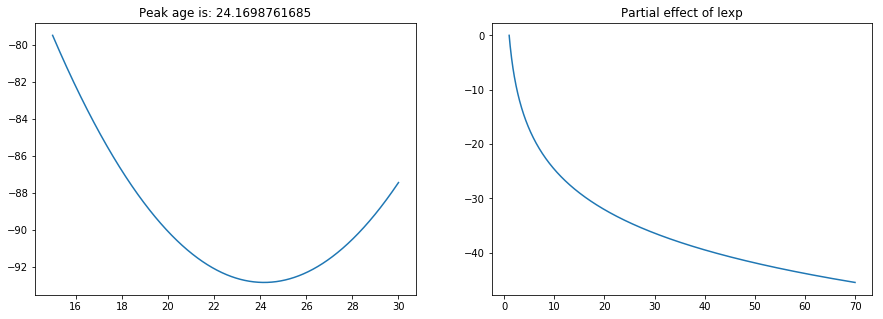

In [38]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
lexp = res.params.lexp*np.log(lexpx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Peak age is: " + str(-res.params.age / (2 * res.params.agesq)))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

In [39]:
pos3 = panel_data[panel_data['pos'] == 3]
pos3.describe()

,perf,age,exp,pos,agesq,const,lexp
count,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000,970.000000
mean,1612.581465,23.263295,25.132990,3.000000,545.850085,1.000000,3.017011
std,90.126954,2.161944,16.479209,0.000000,98.185233,0.000000,0.784631
min,1320.765861,16.331280,0.000000,3.000000,266.710705,1.000000,0.000000
25%,1546.956827,21.954825,12.000000,3.000000,482.014361,1.000000,2.564949
50%,1608.425149,23.575633,22.000000,3.000000,555.810477,1.000000,3.135494
75%,1673.558893,24.699521,36.000000,3.000000,610.066382,1.000000,3.610918
max,1843.687114,27.860370,79.000000,3.000000,776.200195,1.000000,4.382027


In [40]:
Y = pos3['perf']
X = pos3[['age', 'agesq', 'lexp']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.0347
Estimator:,PanelOLS,R-squared (Between):,-0.0855
No. Observations:,970,R-squared (Within):,0.0347
Date:,"Tue, May 01 2018",R-squared (Overall):,-0.0899
Time:,12:21:39,Log-likelihood,-4774.4
Cov. Estimator:,Unadjusted,,
,,F-statistic:,10.699
Entities:,164,P-value,0.0000
Avg Obs:,5.9146,Distribution:,"F(3,893)"
Min Obs:,0.0000,,
Max Obs:,67.000,F-statistic (robust):,10.699


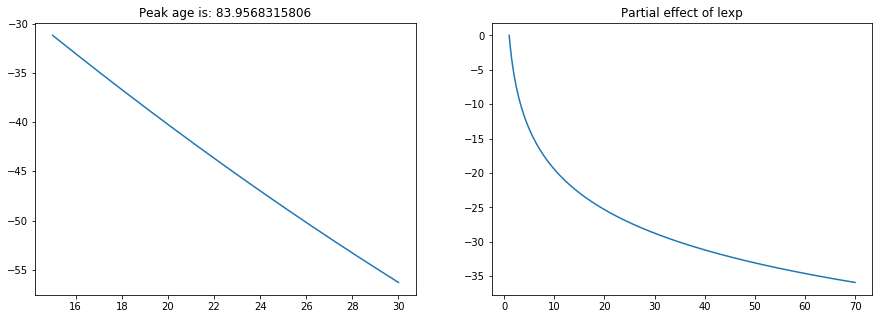

In [41]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
lexp = res.params.lexp*np.log(lexpx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Peak age is: " + str(-res.params.age / (2 * res.params.agesq)))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

In [42]:
pos4 = panel_data[panel_data['pos'] == 4]
pos4.describe()

,perf,age,exp,pos,agesq,const,lexp
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000
mean,1608.656189,22.580755,24.959350,4.000000,516.605199,1.000000,3.023703
std,90.797502,2.592588,16.263859,0.000000,116.743005,0.000000,0.754162
min,1320.765861,16.501027,0.000000,4.000000,272.283882,1.000000,0.000000
25%,1545.307917,20.598220,13.000000,4.000000,424.286689,1.000000,2.639057
50%,1605.287696,22.666667,21.000000,4.000000,513.777785,1.000000,3.091042
75%,1658.885963,24.783710,34.000000,4.000000,614.232272,1.000000,3.555348
max,1907.066627,28.670773,74.000000,4.000000,822.013250,1.000000,4.317488


In [43]:
Y = pos4['perf']
X = pos4[['age', 'agesq', 'lexp']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.0724
Estimator:,PanelOLS,R-squared (Between):,-0.3833
No. Observations:,984,R-squared (Within):,0.0724
Date:,"Tue, May 01 2018",R-squared (Overall):,-0.3851
Time:,12:21:39,Log-likelihood,-4818.2
Cov. Estimator:,Unadjusted,,
,,F-statistic:,23.191
Entities:,162,P-value,0.0000
Avg Obs:,6.0741,Distribution:,"F(3,892)"
Min Obs:,0.0000,,
Max Obs:,52.000,F-statistic (robust):,23.191


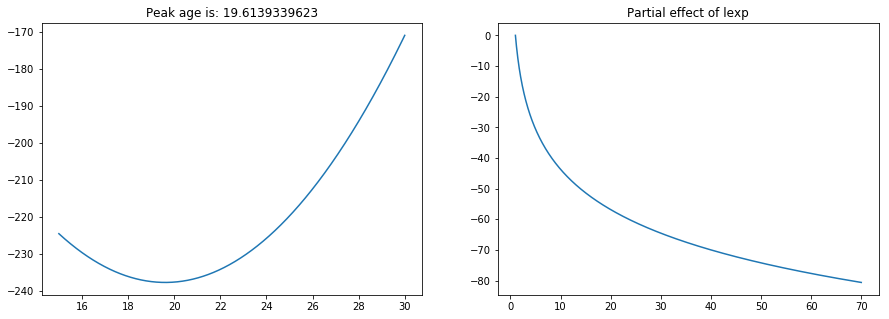

In [44]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
lexp = res.params.lexp*np.log(lexpx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Peak age is: " + str(-res.params.age / (2 * res.params.agesq)))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()

In [45]:
pos5 = panel_data[panel_data['pos'] == 5]
pos5.describe()

,perf,age,exp,pos,agesq,const,lexp
count,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000,963.000000
mean,1597.915727,23.133034,27.503634,5.000000,541.019737,1.000000,3.096566
std,90.114256,2.426643,18.359506,0.000000,112.712572,0.000000,0.786334
min,1304.637290,17.234771,0.000000,5.000000,297.037321,1.000000,0.000000
25%,1533.606904,21.357974,13.000000,5.000000,456.163053,1.000000,2.639057
50%,1595.651001,23.082820,23.000000,5.000000,532.816579,1.000000,3.178054
75%,1642.881428,24.970568,39.000000,5.000000,623.529273,1.000000,3.688879
max,1879.496866,28.629706,79.000000,5.000000,819.660047,1.000000,4.382027


In [46]:
Y = pos5['perf']
X = pos5[['age', 'agesq', 'lexp']]
mod = PanelOLS(Y, X, entity_effects=True)
res = mod.fit()
res.summary

Dep. Variable:,perf,R-squared:,0.0495
Estimator:,PanelOLS,R-squared (Between):,0.1457
No. Observations:,963,R-squared (Within):,0.0495
Date:,"Tue, May 01 2018",R-squared (Overall):,0.1421
Time:,12:21:40,Log-likelihood,-4803.6
Cov. Estimator:,Unadjusted,,
,,F-statistic:,15.291
Entities:,162,P-value,0.0000
Avg Obs:,5.9444,Distribution:,"F(3,881)"
Min Obs:,0.0000,,
Max Obs:,53.000,F-statistic (robust):,15.291


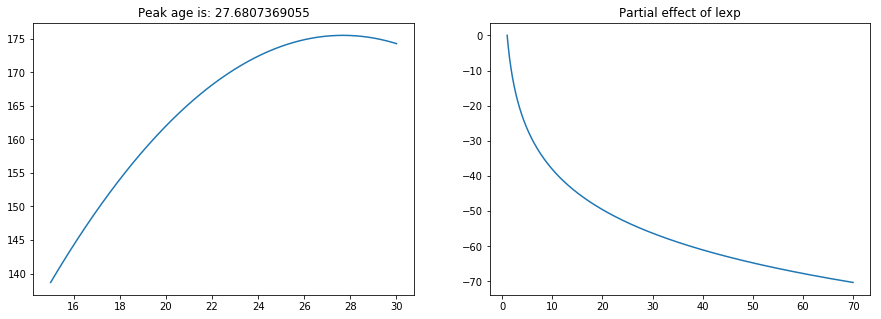

In [47]:
# create 1000 equally spaced points between -10 and 10
agex = np.linspace(15, 30, 1000)
lexpx = np.linspace(1, 70, 1000)
# calculate the y value for each element of the x vector
age = res.params.agesq*agex**2 + res.params.age*agex 
lexp = res.params.lexp*np.log(lexpx)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(agex, age)
ax[0].set_title("Peak age is: " + str(-res.params.age / (2 * res.params.agesq)))
ax[1].plot(lexpx, lexp)
ax[1].set_title("Partial effect of lexp")
plt.show()